In [1]:
pwd

'c:\\Users\\82438\\OneDrive - HKUST Connect\\23Fall\\MAFS6010Z_AI for Fintech\\warmup'

In [2]:
import os
for dirname, _, filenames in os.walk('./home-credit-default-risk'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./home-credit-default-risk\application_test.csv
./home-credit-default-risk\application_train.csv
./home-credit-default-risk\bureau.csv
./home-credit-default-risk\bureau_balance.csv
./home-credit-default-risk\credit_card_balance.csv
./home-credit-default-risk\HomeCredit_columns_description.csv
./home-credit-default-risk\installments_payments.csv
./home-credit-default-risk\POS_CASH_balance.csv
./home-credit-default-risk\previous_application.csv
./home-credit-default-risk\sample_submission.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.reset_option("display.max_columns", 200)
pd.reset_option("display.max_rows", 200)

from tqdm import tqdm

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import os
import torch
cpuCount = os.cpu_count()
print("CPU:", cpuCount)
print('GPU：', torch.cuda.device_count())


CPU: 8
GPU： 1


In [6]:
applytrain = pd.read_csv("./home-credit-default-risk/application_train.csv")
applytest = pd.read_csv("./home-credit-default-risk/application_test.csv")

In [7]:
features = pd.read_csv("./output/features.csv", index_col=0)

C:\Users\82438\AppData\Roaming\Python\Python37\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (797,798,799,800,801,802,803,804,805,806,807,808,809,810,811,812) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
features.head().T

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,202500.0,270000.0,67500.0,135000.0,121500.0
AMT_CREDIT,406597.5,1293502.5,135000.0,312682.5,513000.0
AMT_ANNUITY,24700.5,35698.5,6750.0,29686.5,21865.5
...,...,...,...,...,...
ORGANIZATION_TYPE,NaN,NaN,NaN,NaN,NaN
FONDKAPREMONT_MODE,NaN,NaN,NaN,NaN,NaN
HOUSETYPE_MODE,NaN,NaN,NaN,NaN,NaN
WALLSMATERIAL_MODE,NaN,NaN,NaN,NaN,NaN


In [9]:
missing_dict = {}
for col in tqdm(features.columns):
    missing_dict[col] = features[col].isnull().sum() / features.shape[0]

  0%|          | 0/812 [00:00<?, ?it/s]100%|██████████| 812/812 [00:03<00:00, 258.56it/s]


### Data Cleaning

#### delete those features whose missing rate over 90\%

In [10]:
feacols = [col for col in missing_dict.keys() if missing_dict[col] <= 0.9]
feacols.remove('SK_ID_CURR')

In [11]:
print(f'Number of features before deletion:{len(missing_dict.keys()) - 1}')
print(f'Number of features after deletion:{len(feacols)}')

删除前的特征数量:811
删除后的特征数量:796


#### Split into train and test

In [12]:
print(features.shape[0], applytrain.shape[0]+applytest.shape[0])
features = pd.merge(features, applytrain[['SK_ID_CURR', 'TARGET']], how='left', left_on=['SK_ID_CURR'], right_on=['SK_ID_CURR'])
print(features.shape)

356255 356255
(356255, 813)


In [13]:
features['TARGET'].value_counts(dropna=False)

0.0    282686
NaN     48744
1.0     24825
Name: TARGET, dtype: int64

In [14]:
applytest.shape
## check over

(48744, 121)

In [15]:
del applytrain
del applytest

In [16]:
strcols = []
for col in tqdm(feacols):
    if features[col].dtypes not in ['int64', 'float64']:
        try:
            features[col] = pd.to_numeric(features[col])
        except Exception as e:
            print(col)
            strcols.append(col)

 99%|█████████▉| 788/796 [00:00<00:00, 2595.08it/s]

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS


100%|██████████| 796/796 [00:00<00:00, 1399.12it/s]

NAME_HOUSING_TYPE
WEEKDAY_APPR_PROCESS_START
ORGANIZATION_TYPE


In [17]:
feacols = [col for col in feacols if col not in strcols]

In [18]:
def replace_nm(s, str1, str2):
    for string in str1:
        s = s.replace(string, str2)
    return s
replace_nm('abc', ['a', 'b'], '_')

'__c'

In [19]:
features.rename(columns={col:replace_nm(col, ['(', ')', '.'], '_') for col in features.columns}, inplace=True)
feacols = [replace_nm(col, ['(', ')', '.'], '_') for col in feacols]

#### normalization
Because we choose the tree model, we don’t need to do norm.

In [20]:
# from sklearn import preprocessing 

# features[feacols] = preprocessing.scale(features[feacols])

#### fillna
Because nan values may have unique meanings in actual application scenarios, they are not intended to be filled.

In [21]:
# features[feacols] = features[feacols].fillna(0)

In [20]:
X = features[(features['TARGET'].isnull() == False)]
test = features[(features['TARGET'].isnull() == True)]
print(X.shape, test.shape)

(307511, 813) (48744, 813)


### choosing features

In [21]:
X['TARGET'].value_counts(normalize=True)

0.0    0.919271
1.0    0.080729
Name: TARGET, dtype: float64

In [22]:
X['TARGET'].value_counts(normalize=False)

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

#### SMOTE
SMOTE sampling was not used due to insufficient resources, so we chose to add the class_weight parameter to the model to weight each category in the training set and act on the loss function. This makes the model pay more attention to categories with a small number of samples. If there are many samples in a certain category, its weight will be low, otherwise its weight will be high.

In [24]:
# X = pd.concat([X[X['TARGET'] == 1], X[X['TARGET'] == 0].sample(50000, random_state=0)]) # 这个欠采样不选用

In [25]:
from sklearn.model_selection import train_test_split

# train:test:dev = 8:1:1
X_train, X_test, y_train, y_test = train_test_split(X[feacols], X['TARGET'], test_size=0.2, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(X[feacols], X['TARGET'], test_size=0.5, random_state=42)

#### Compare which is faster with a CPU or a GPU

In [26]:
y_train.value_counts()

0.0    226132
1.0     19876
Name: TARGET, dtype: int64

In [27]:
%%time
from lightgbm import LGBMClassifier

params = {'n_estimators':500
         ,'early_stopping':100
         ,'num_leaves': 11
         ,'max_depth':5
         ,'learning_rate':0.05
         ,'n_jobs':8
         ,'class_weight':'balanced'}

lgb = LGBMClassifier(**params)
lgb.fit(X_train, y_train, eval_metric=['rmse', 'mae'], eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.182130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 146681
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 779
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.420386	training's l1: 0.373136	training's binary_logloss: 0.530191	valid_1's rmse: 0.421782	valid_1's l1: 0.

LGBMClassifier(class_weight='balanced', early_stopping=100, learning_rate=0.05,
               max_depth=5, n_estimators=500, n_jobs=8, num_leaves=11)

In [29]:
%%time
from lightgbm import LGBMClassifier

params = {'n_estimators':500
         ,'early_stopping':100
         ,'num_leaves': 11
         ,'max_depth':5
         ,'learning_rate':0.05
         ,'device':'gpu'
         ,'gpu_device_id':0
         ,'class_weight':'balanced'
         }

lgb = LGBMClassifier(**params)
lgb.fit(X_train, y_train, eval_metric=['rmse', 'mae'], eval_set=[(X_train, y_train), (X_test, y_test)])

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 146681
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 779
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 630, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 500 dense feature groups (117.31 MB) transferred to GPU in 0.099426 secs. 1 sparse feature groups
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.00000

LGBMClassifier(class_weight='balanced', device='gpu', early_stopping=100,
               gpu_device_id=0, learning_rate=0.05, max_depth=5,
               n_estimators=500, num_leaves=11)

#### find out that gpu-lightgbm is no faster than CPU

### Screening Characteristics

#### find features who are important

In [30]:
IM = pd.DataFrame().from_dict(dict(zip(feacols, lgb.feature_importances_)), orient='index', columns=['im']).sort_values(by=['im'], ascending=False)
IM.head(200)

,im
EXT_SOURCE_1,210
EXT_SOURCE_2,174
EXT_SOURCE_3,164
AMT_CREDIT,118
AMT_ANNUITY,107
...,...
FLAG_DOCUMENT_13,6
MEAN_bureau_SKEW_Bureau_balance_STATUS_invsd__,6
MIN_POS_CASH_balance_CNT_INSTALMENT_,6
MAX_Bureau_balance_bureau_DAYS_CREDIT_ENDDATE_,6


In [31]:
IM.shape, IM[(IM['im'] > 0)].shape

((785, 1), (578, 1))

In [32]:
feacols2 = list(IM[(IM['im'] > 0)].index)

In [33]:
import joblib
# Save incoming variables
joblib.dump(feacols2, "./feacols2.pkl")

['./feacols2.pkl']

#### Grid search to find the best parameters

In [34]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[500, 1000]
         ,'num_leaves': [5, 11]
         ,'max_depth':[5, 10]
         ,'learning_rate':[0.05]
         ,'n_jobs':[8]
         ,'class_weight':['balanced']}

lgb = LGBMClassifier()
grid_search = GridSearchCV(lgb, params)

grid_search.fit(X_train[feacols2], y_train)

[LightGBM] [Info] Number of positive: 15901, number of negative: 180905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.569761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125958
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 578
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 15901, number of negative: 180905
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.282475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125819
[LightGBM] [Info] Number of data points in the train set: 196806, number of used features: 578
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[Light

GridSearchCV(estimator=LGBMClassifier(),
             param_grid={'class_weight': ['balanced'], 'learning_rate': [0.05],
                         'max_depth': [5, 10], 'n_estimators': [500, 1000],
                         'n_jobs': [8], 'num_leaves': [5, 11]})

In [35]:
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'class_weight': 'balanced', 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000, 'n_jobs': 8, 'num_leaves': 11}
Best score:  0.7468618950734365


In [36]:
import joblib
feacols2 = joblib.load("./feacols2.pkl")
len(feacols2)

578

In [37]:
from lightgbm import LGBMClassifier

params = {'learning_rate': 0.05
          ,'max_depth': 10
          ,'n_estimators': 1000
          ,'n_jobs': 8
          ,'num_leaves': 11
          ,'class_weight':'balanced'}
lgb = LGBMClassifier(**params)
lgb.fit(X_train[feacols2], y_train, eval_metric=['rmse', 'mae'], eval_set=[(X_train[feacols2], y_train), (X_test[feacols2], y_test)])

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.624451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 125858
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 578
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', learning_rate=0.05, max_depth=10,
               n_estimators=1000, n_jobs=8, num_leaves=11)

#### model evaluation

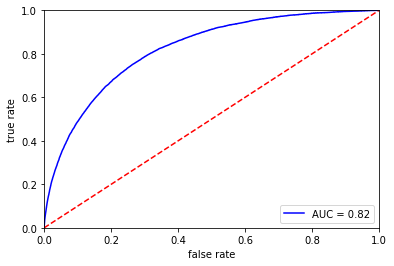

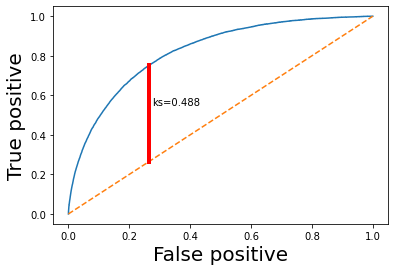

In [44]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

y_pred = lgb.predict_proba(X_dev[feacols2])[:, -1]

fpr, tpr, thresholds = roc_curve(y_dev, y_pred)

#Calculate ROC and plot the curve
rocauc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % rocauc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('true rate')
plt.xlabel('false rate')
plt.show()
    
ks_value = max(abs(fpr-tpr))
#ROC curve
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')
#plot KS
x = np.argwhere(abs(fpr-tpr) == ks_value)[0, 0]
plt.plot([fpr[x], fpr[x]], [fpr[x], tpr[x]], linewidth=4, color='r')
plt.text(fpr[x]+0.01,tpr[x]-0.2, 'ks='+str(format(ks_value,'0.3f')),color= 'black')
plt.xlabel('False positive', fontsize=20)
plt.ylabel('True positive', fontsize=20)
plt.show()

In [45]:
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score
import seaborn as sns
print('confusion matrix:')
print(confusion_matrix(y_dev, lgb.predict(X_dev[feacols2])))
print("f1-score: {:.2f}".format(f1_score(y_dev, lgb.predict(X_dev[feacols2]))))
print("f_beta-score(beta=2): {:.2f}".format(fbeta_score(y_dev, lgb.predict(X_dev[feacols2]), beta=2)))

confusion matrix:
[[106412  34912]
 [  3332   9100]]
f1-score: 0.32
f_beta-score(beta=2): 0.49


<AxesSubplot:ylabel='feature name'>

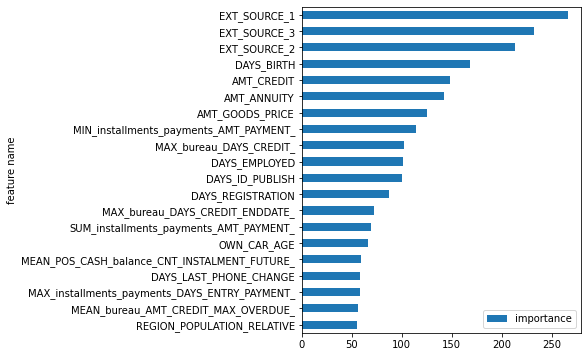

In [46]:
df = pd.DataFrame()
df['feature name'] = lgb.feature_name_
df['importance'] = lgb.feature_importances_
df = df.sort_values('importance')
df.tail(20).plot.barh(x = 'feature name',figsize=(5,6))

#### save model..

In [47]:
import joblib
joblib.dump(lgb, "./lgb.pkl")

['./lgb.pkl']

### predict


In [48]:
test['TARGET'] = lgb.predict(test[feacols2])

C:\Users\82438\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
test[['SK_ID_CURR', 'TARGET']].to_csv("./submission.csv", index=False, sep=',')

#### Finally Put in kaggle result of 0.69329